# SUDHIR SHARMA
# ID NO - 12041500
# CSE
# CS 550 ASSIGNMENT_1_PARTB

In [172]:
# !pip install -q kaggle

In [173]:
# from google.colab import files
# files.upload()

In [174]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [175]:
# !kaggle competitions download -c new-york-city-taxi-fare-prediction

In [176]:
# !unzip new-york-city-taxi-fare-prediction

In [2]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import haversine as hs 

import math
from math import sqrt

from numpy import absolute
from numpy import mean
from numpy import std

from sklearn import metrics
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn import neighbors

!pip install tensorflow
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredError 
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
!pip install haversine 
from tensorflow.random import set_seed
!pip install xgboost
import xgboost as xgb


#### There is a lot of data, which will require a lot of computing resources, so I took only a part of it

In [3]:
# Read data in pandas dataframe, 

train = pd.read_csv("content/train.csv", nrows = 1000000)                   
test = pd.read_csv("content/test.csv")

In [4]:
print(train.shape)
print(test.shape)

(1000000, 8)
(9914, 7)


In [5]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [6]:
train.dtypes   # Cheking Data Type of train

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [7]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


## From this we learn that
* The minimum fare is negative, which is impossible
* Some travel points are missing the city
* The maximum number of passengers is equal to 208, which is impossible
* The maximum fare also unreal

#  A Data Cleaning & Feature Engineering

#### Find, if we have data that has no value

In [8]:
print(train.isnull().sum())

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    10
dropoff_latitude     10
passenger_count       0
dtype: int64



**longitude and latitude**

found NaN values in columns dropoff_longitude and dropoff_latitude     
We found NaN values in columns

i) dropoff_longitude and 

ii) dropoff_latitude  

which is not much as comapared to our trainset. So we will Drop it.


In [9]:
train = train.dropna(how = 'any', axis = 'rows')  # dropping NULL value

In [10]:
print('Old size: %d' % len(train))

Old size: 999990


#### There will be no negative tax and you may not be able to pay more than a certain limit depending on the circumstances, let's say this limit is 200\\$ 
Also, I came to know from google that the minimum fare for a New York taxi is 2,50\\$  

In [11]:
train = train.drop(train[train.fare_amount<2.5].index, axis = 0)    #Droping fare_amount <$2.5
train = train.drop(train[train.fare_amount>300].index, axis = 0)    #Droping fare_amount >$300

#### Delete the data whose passenger_count exceeded 7, because it cannot physically fit more in the taxi and it is not allowed. Taxi can also move without passenger and carry cargo, so lets permit passenger_count == 0 data


In [12]:
train['passenger_count'][train.passenger_count==0].count()

3555

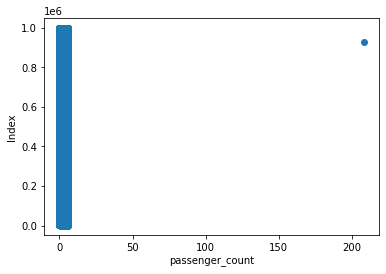

In [13]:
plt.scatter(x=train.passenger_count,y=train.index)
plt.ylabel('Index')
plt.xlabel('passenger_count')
plt.show()

In [14]:
train.drop(train[train.passenger_count==0].index,axis=0,inplace=True)   # passenger count ==0 hav e been removed

In [15]:
train = train.drop(train[train['passenger_count']>7].index, axis = 0)  # we have Assumed that maximum Number of passenger can sit in taxi will be 7
train = train.drop(train[train['passenger_count']<=0].index, axis = 0)  # Droping taxi taking fare without passengers

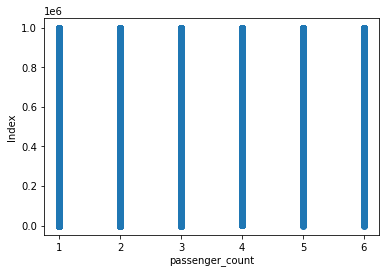

In [16]:
plt.scatter(x=train.passenger_count,y=train.index)
plt.ylabel('Index')
plt.xlabel('passenger_count')
plt.show()

#### Remove the pickup_latitude data whose values are greater than 90 and less than -90, because latitudes are between -90 and 90 degrees

In [192]:
train = train.drop(train[train['pickup_latitude']<-90].index, axis = 0)
train = train.drop(train[train['pickup_latitude']>90].index, axis = 0)

#### Remove the pickup_longitude data whose values are greater than 180 and less than -180, because longitudes are between -180 and 180 degrees

In [193]:
train = train.drop(train[train['pickup_longitude']<-180].index, axis = 0)
train = train.drop(train[train['pickup_longitude']>180].index, axis = 0)

#### Repeat the same for dropoff_latitude and dropoff_longitude

In [194]:
train = train.drop(train[train['dropoff_latitude']<-90].index, axis = 0)
train = train.drop(train[train['dropoff_latitude']>90].index, axis = 0)

train = train.drop(train[train['dropoff_longitude']<-180].index, axis = 0)
train = train.drop(train[train['dropoff_longitude']>180].index, axis = 0)

#### The geographical location may correspond to the real one, but not to New York area, so let's filter the existing data. For this, let's introduce the conditional city limits

In [195]:
def select_outside_boundingbox(df, BB):
    filter_df = df.loc[(df['pickup_longitude'] < BB[0]) | (df['pickup_longitude'] > BB[1]) | \
           (df['pickup_latitude'] < BB[2]) | (df['pickup_latitude'] > BB[3]) | \
           (df['dropoff_longitude'] < BB[0]) | (df['dropoff_longitude'] > BB[1]) | \
           (df['dropoff_latitude'] < BB[2]) | (df['dropoff_latitude'] > BB[3])]
    
    return filter_df

NYC_BB = (-74.5, -72.8, 40.5, 41.8)         #   dropping data which has lon_min (-74.263242) > here are 151 data > lon_max ( -72.986532) 
                                             # in simple 
                                             #  dropping data are out of range of NYC_BB

In [196]:
outliers = select_outside_boundingbox(train, NYC_BB)
outliers

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
11,2012-12-24 11:24:00.00000098,5.5,2012-12-24 11:24:00 UTC,0.0,0.0,0.0,0.0,3
15,2013-11-23 12:57:00.000000190,5.0,2013-11-23 12:57:00 UTC,0.0,0.0,0.0,0.0,1
26,2011-02-07 20:01:00.000000114,6.5,2011-02-07 20:01:00 UTC,0.0,0.0,0.0,0.0,1
124,2013-01-17 17:22:00.00000043,8.0,2013-01-17 17:22:00 UTC,0.0,0.0,0.0,0.0,2
192,2010-09-05 17:08:00.00000092,3.7,2010-09-05 17:08:00 UTC,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...
999713,2013-06-07 20:40:21.0000003,8.0,2013-06-07 20:40:21 UTC,0.0,0.0,0.0,0.0,2
999723,2013-03-03 13:18:00.000000227,3.5,2013-03-03 13:18:00 UTC,0.0,0.0,0.0,0.0,6
999731,2014-05-04 23:27:00.000000103,9.0,2014-05-04 23:27:00 UTC,0.0,0.0,0.0,0.0,6
999888,2010-04-28 21:08:00.00000038,9.3,2010-04-28 21:08:00 UTC,0.0,0.0,0.0,0.0,3


In [197]:
train = train.drop(outliers.index, axis = 0)    #data are out of range of NYC_BB comes to be 20884  we have to drop it

In [198]:
print('New size: %d' % len(train))

New size: 975498


In [199]:
#key column and pickup_datetime column of Test set should also be presented as time data
test['key'] = pd.to_datetime(test['key'])
test['pickup_datetime']  = pd.to_datetime(test['pickup_datetime'])

In [200]:
test.dtypes

key                       datetime64[ns]
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

Negative fare Removed 

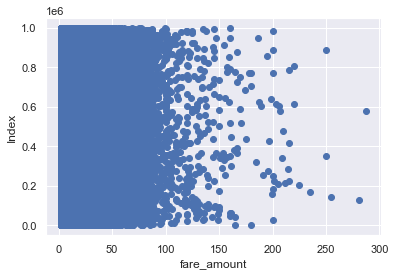

In [201]:
plt.scatter(x=train.fare_amount,y=train.index)
plt.ylabel('Index')
plt.xlabel('fare_amount')
plt.show()

In [202]:
print("Number of Fare_amount <=0 is")
train['fare_amount'][(train.fare_amount<=0)].count()

Number of Fare_amount <=0 is


0

In [203]:
train.shape

(975498, 8)

Final checking if still some outliers are left

In [204]:
train.drop(train[train.dropoff_longitude.isnull()==True].index,axis=0,inplace=True)

In [205]:
print('Number of observations out of valid range in coordinate columns:', end="\n")

print('pickup_longitude', end=': ')
print((train.pickup_longitude <-180).sum()+(train.pickup_longitude > 180).sum())

print('pickup_latitude', end=': ')
print((train.pickup_latitude <-90).sum()+(train.pickup_latitude > 90).sum())

print('dropoff_longitude', end=': ')
print((train.dropoff_longitude <-180).sum()+(train.dropoff_longitude > 180).sum())

print('dropoff_latitude', end=': ')
print((train.dropoff_latitude <-90).sum()+(train.dropoff_latitude > 90).sum())

if(((train.pickup_longitude <-180).sum()+(train.pickup_longitude > 180).sum() and (train.pickup_latitude <-90).sum()+(train.pickup_latitude > 90).sum() and (train.dropoff_longitude <-180).sum()+(train.dropoff_longitude > 180).sum() and (train.dropoff_latitude <-90).sum()+(train.dropoff_latitude > 90).sum())==0):
    print("No OutLiers Left")
else:
    print("Outliers Still Left")    

Number of observations out of valid range in coordinate columns:
pickup_longitude: 0
pickup_latitude: 0
dropoff_longitude: 0
dropoff_latitude: 0
No OutLiers Left


#### We can understand displacement through start and end points.

#### We will use the Haversine formula to calculate the distance between two geolocations

In [206]:

train["loc1"] = train[["pickup_latitude","pickup_longitude"]].apply(tuple, axis=1)
train["loc2"] = train[["dropoff_latitude","dropoff_longitude"]].apply(tuple, axis=1)

**Distance **

Calculate the distance based on longitude and latitude 

Haversine formula:

dlon = lon2 - lon1 
dlat = lat2 - lat1 
a = (sin(dlat/2))^2 + cos(lat1) * cos(lat2) * (sin(dlon/2))^2 
c = 2 * atan2( sqrt(a), sqrt(1-a) ) 
d = R * c (where R is the radius of the Earth)

#a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
#c = 2 ⋅ atan2( √a, √(1−a) )
#d = R ⋅ c 

In [207]:
def haversine_distance(lat1, long1, lat2, long2):
    dat = [train, test]
    for i in dat:
        R = 6371  #radius of earth in kilometers
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        i['H_Distance'] = d
    return d

#### Let's also calculate the distance using the Chebyshev method

The Chebyshev iteration is an iterative method for determining the solutions of a system of linear equations.

**Reference**
https://brilliant.org/wiki/chebyshevs-formula/#:~:text=x%20%3D%20a%20%2B%20b%202%20%2B,%3D1%2C%20t%3D1%2C&text=x%3Db.,-Hence%2C

In [208]:
def chebyshev(pickup_long, dropoff_long, pickup_lat, dropoff_lat):
    return np.maximum(np.absolute(pickup_long - dropoff_long), np.absolute(pickup_lat - dropoff_lat))

train['Chebyshev'] = chebyshev(train['pickup_longitude'], train['dropoff_longitude'], train['pickup_latitude'], train['dropoff_latitude'])

In [209]:
test.dtypes

key                       datetime64[ns]
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [210]:
haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

0        2.323260
1        2.425353
2        0.618628
3        1.961033
4        5.387301
          ...    
9909     2.124874
9910     3.270969
9911    19.183941
9912     8.343486
9913     1.180825
Length: 9914, dtype: float64

In [211]:
dis=train["fare_amount"]/(train["H_Distance"]*train["passenger_count"])
fare_by_distance=train["fare_amount"]/train["H_Distance"]
len(dis)

975498

In [212]:
#drop outliers
train["fare_by_distance"]=fare_by_distance
train['dis']=dis
train=train[train['dis']>=.1]
train=train[train['dis']<=7]

In [213]:
len(train)

900400

<AxesSubplot:xlabel='passenger_count', ylabel='fare_by_distance'>

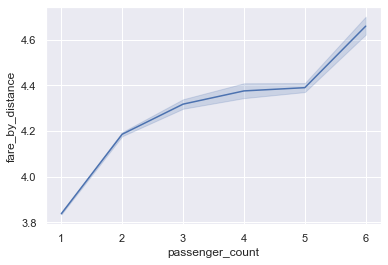

In [214]:
sns.lineplot(x="passenger_count", y="fare_by_distance", data=train)

**Type conversion (train formating) :pickup_datetime**

In [215]:
train['key'] = pd.to_datetime(train['key'])
train['pickup_datetime']  = pd.to_datetime(train['pickup_datetime'])

In [216]:
test['key']=pd.to_datetime(test['key'])
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'])

In [217]:
train["Hour"] = train['pickup_datetime'].dt.hour
train["day_of_week"] = train['pickup_datetime'].dt.weekday
train["day_of_month"] = train['pickup_datetime'].dt.day
train["week"] = train['pickup_datetime'].dt.week
train["month"] = train['pickup_datetime'].dt.month
train["year"] = train['pickup_datetime'].dt.year - 2000

train['minute'] =train['pickup_datetime'].dt.minute
train['second'] = train['pickup_datetime'].dt.second
train['dayofyear'] = train['pickup_datetime'].dt.dayofyear

C:\Users\SUDHIR~1\AppData\Local\Temp/ipykernel_6300/2236433926.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  train["week"] = train['pickup_datetime'].dt.week


In [218]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,loc1,loc2,...,dis,Hour,day_of_week,day_of_month,week,month,year,minute,second,dayofyear
0,2009-06-15 17:26:21.000000100,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,"(40.721319, -73.844311)","(40.712278, -73.84161)",...,4.365694,17,0,15,25,6,9,26,21,166
1,2010-01-05 16:52:16.000000200,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,"(40.711303, -74.016048)","(40.782004, -73.979268)",...,1.999968,16,1,5,1,1,10,52,16,5
2,2011-08-18 00:35:00.000000490,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,"(40.76127, -73.982738)","(40.750562, -73.991242)",...,2.051060,0,3,18,33,8,11,35,0,230
3,2012-04-21 04:30:42.000000100,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,"(40.733143, -73.98713)","(40.758092, -73.991567)",...,2.750717,4,5,21,16,4,12,30,42,112
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,"(40.768008, -73.968095)","(40.783762, -73.956655)",...,2.651118,7,1,9,10,3,10,51,0,68


#### Add a variable that determines how much each kilometer of travel costs

In [219]:
train["fare_to_dist_ratio"] = train["fare_amount"] / ( train["H_Distance"]+0.0001)

#### Remove those whose start and end points match

In [220]:
train = train.drop(train[train['loc1']==train['loc2']].index, axis = 0)


### Let's repeat the same procedures on the test part

In [221]:
test['pickup_datetime']  = pd.to_datetime(test['pickup_datetime'])

test["loc1"] = test[["pickup_latitude","pickup_longitude"]].apply(tuple, axis=1)
test["loc2"] = test[["dropoff_latitude","dropoff_longitude"]].apply(tuple, axis=1)

test['H_Distance'] = test.apply(lambda row: hs.haversine(row.loc1,row.loc2), axis=1)

test['Chebyshev'] = chebyshev(test['pickup_longitude'], test['dropoff_longitude'], test['pickup_latitude'], test['dropoff_latitude'])


test["hour"] = test.pickup_datetime.dt.hour
test["day_of_week"] = test.pickup_datetime.dt.weekday
test["day_of_month"] = test.pickup_datetime.dt.day
test["week"] = test.pickup_datetime.dt.week
test["month"] = test.pickup_datetime.dt.month
test["year"] = test.pickup_datetime.dt.year - 2000

test['minute'] =test['pickup_datetime'].dt.minute
test['second'] = test['pickup_datetime'].dt.second
test['dayofyear'] = test['pickup_datetime'].dt.dayofyear

# test = add_distances_from_airport(test)

C:\Users\SUDHIR~1\AppData\Local\Temp/ipykernel_6300/4156851343.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  test["week"] = test.pickup_datetime.dt.week


In [222]:
def downcast(df):

    df_int = df.select_dtypes(include=['int64', 'int32', 'int16', 'int8', 'int'])
    df[df_int.columns] = df_int.apply(pd.to_numeric,downcast='unsigned')
    
    df_float = df.select_dtypes(include=['float64', 'float32', 'float16', 'float'])
    df[df_float.columns] = df_float.apply(pd.to_numeric,downcast='float')
        
    return df
downcast(train)
downcast(test)
train.dtypes

key                        datetime64[ns]
fare_amount                       float32
pickup_datetime       datetime64[ns, UTC]
pickup_longitude                  float32
pickup_latitude                   float32
dropoff_longitude                 float32
dropoff_latitude                  float32
passenger_count                     uint8
loc1                               object
loc2                               object
Chebyshev                         float32
H_Distance                        float32
fare_by_distance                  float32
dis                               float32
Hour                                uint8
day_of_week                         uint8
day_of_month                        uint8
week                                uint8
month                               uint8
year                                uint8
minute                              uint8
second                              uint8
dayofyear                          uint16
fare_to_dist_ratio                

## Map visualization


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


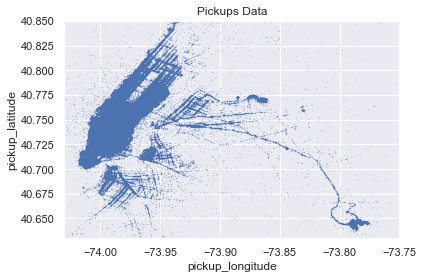

In [223]:
train.plot(y='pickup_latitude',x='pickup_longitude',kind="scatter",alpha=0.7,s=0.02)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.title("Pickups Data")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


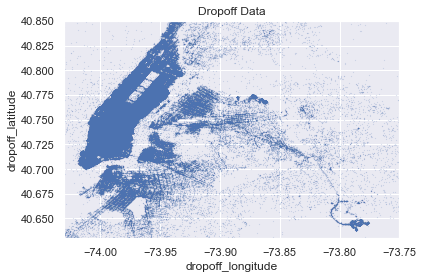

In [224]:
train.plot(y='dropoff_latitude',x='dropoff_longitude',kind="scatter",alpha=0.5,s=0.02)
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.title("Dropoff Data")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

## Exploratory Data Analysis

(0.0, 100.0)

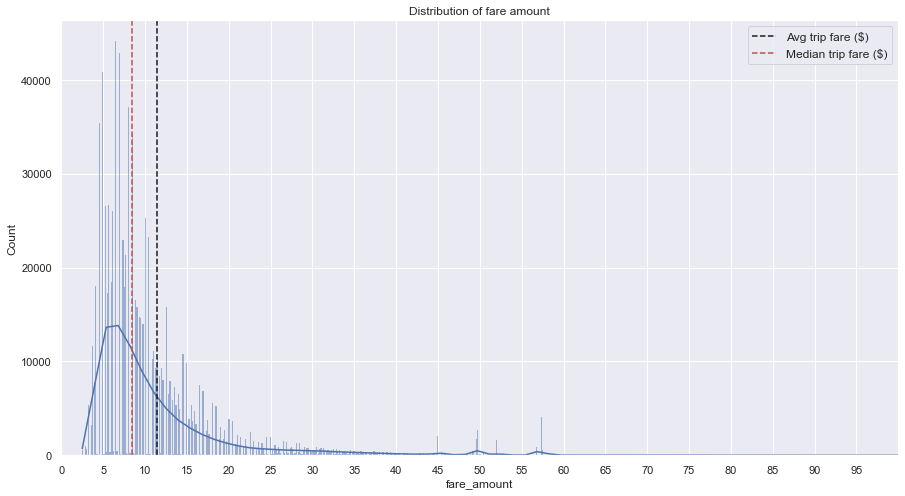

In [225]:
sns.histplot(data=train,x="fare_amount",kde=True)

plt.axvline(train["fare_amount"].mean(),color = "k",
            linestyle = "dashed",label = "Avg trip fare ($)")
plt.axvline(train["fare_amount"].median(),color = "r",
            linestyle = "dashed",label = "Median trip fare ($)")

plt.title("Distribution of fare amount")
plt.xticks(np.arange(0, 100, step=5))
plt.legend(loc = "best",prop = {"size" : 12})
plt.gcf().set_size_inches(15,8)
plt.xlim(0,100)

##### A right-skewed distribution
* #### Most taxi fares range from $2.5\\$-20\\$.
* #### The average taxi fee varies between 10\\$-12\\$
* #### 45\\$-50\\$-57\\$ peaks are observed, which fixed fee

(0.0, 30.0)

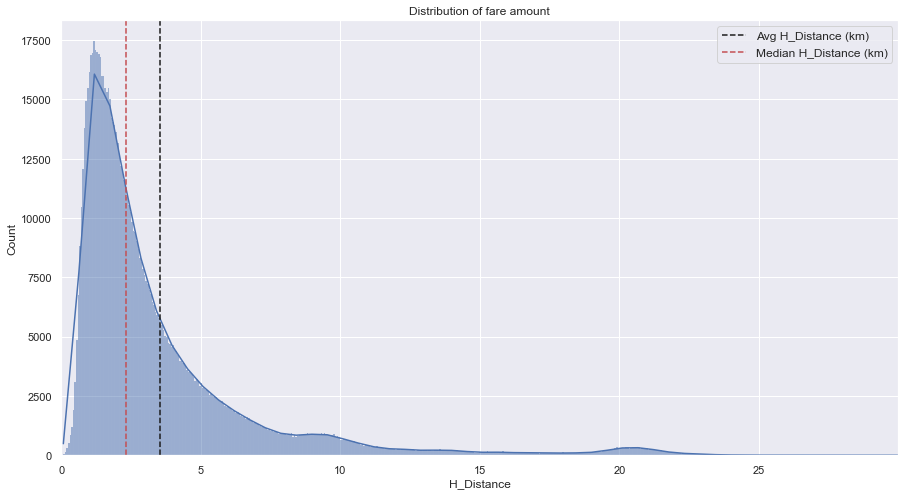

In [226]:
sns.histplot(data=train,x="H_Distance",kde=True)

plt.axvline(train["H_Distance"].mean(),color = "k",
            linestyle = "dashed",label = "Avg H_Distance (km)")
plt.axvline(train["H_Distance"].median(),color = "r",
            linestyle = "dashed",label = "Median H_Distance (km)")

plt.title("Distribution of fare amount")
plt.xticks(np.arange(0, 30, step=5))
plt.legend(loc = "best",prop = {"size" : 12})
plt.gcf().set_size_inches(15,8)
plt.xlim(0,30)

* #### Passengers travel an average of 3-5 km by taxi

#### 1. Does the number of passengers affect the fare?

Text(0, 0.5, 'Frequency')

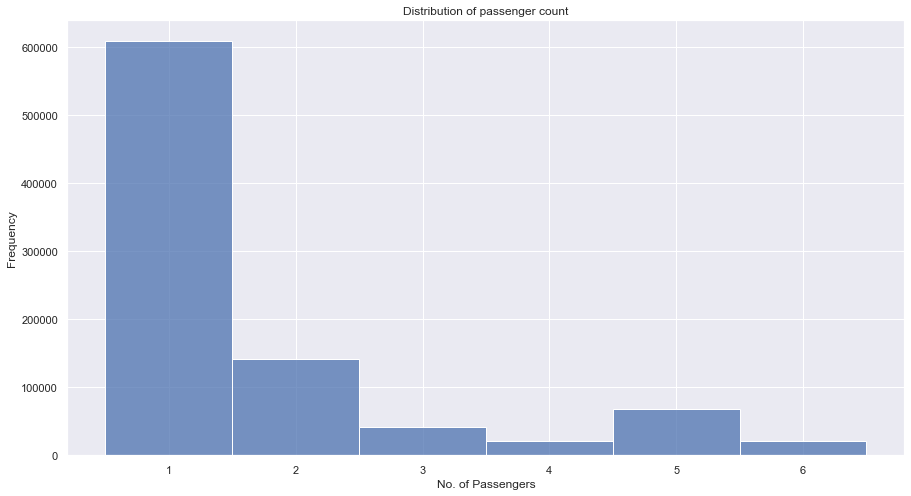

In [227]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.histplot(data=train, x="passenger_count", stat="count", discrete=True)
plt.title("Distribution of passenger count")
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

* #### Most of the passengers were traveling alone

Text(0, 0.5, 'Fare')

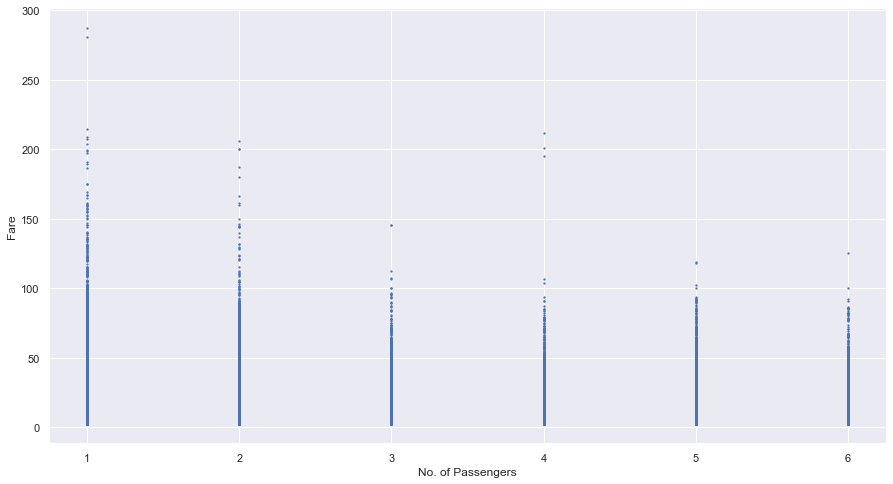

In [228]:
plt.figure(figsize=(15,8))
plt.scatter(x=train['passenger_count'], y=train['fare_amount'], s=1.5)
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')

* #### One-passenger taxi has more passengers whose fare is higher

#### 2. Does the date and time of pickup affect the fare?

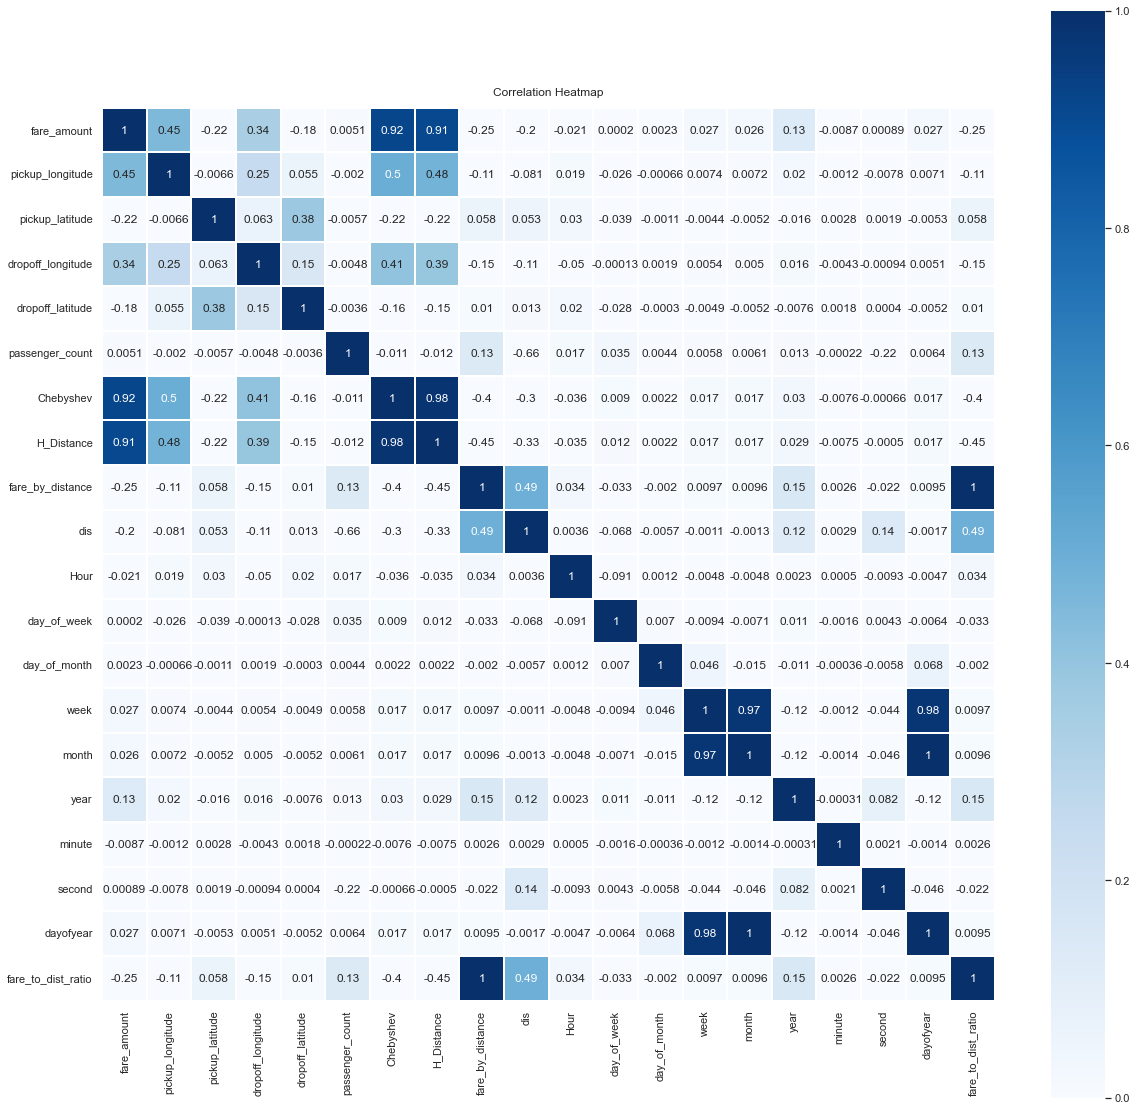

In [229]:
colormap = plt.cm.RdBu
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(train.corr(),linewidths=0.1,vmax=1.0,vmin=0, 
            square=True, cmap="Blues", linecolor='white', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Text(0, 0.5, 'Fare')

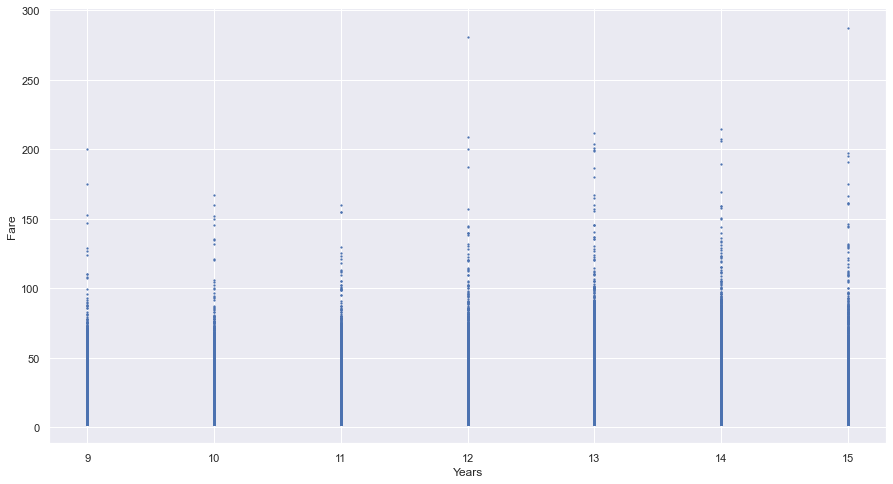

In [230]:
plt.figure(figsize=(15,8))
plt.scatter(x=train['year'], y=train['fare_amount'], s=1.5)
plt.xlabel('Years')
plt.ylabel('Fare')

In [231]:
train[['fare_amount','year']].corr()

,fare_amount,year
fare_amount,1.000000,0.130865
year,0.130865,1.000000


* #### The rate does not change significantly over the years

Text(0, 0.5, 'Fare')

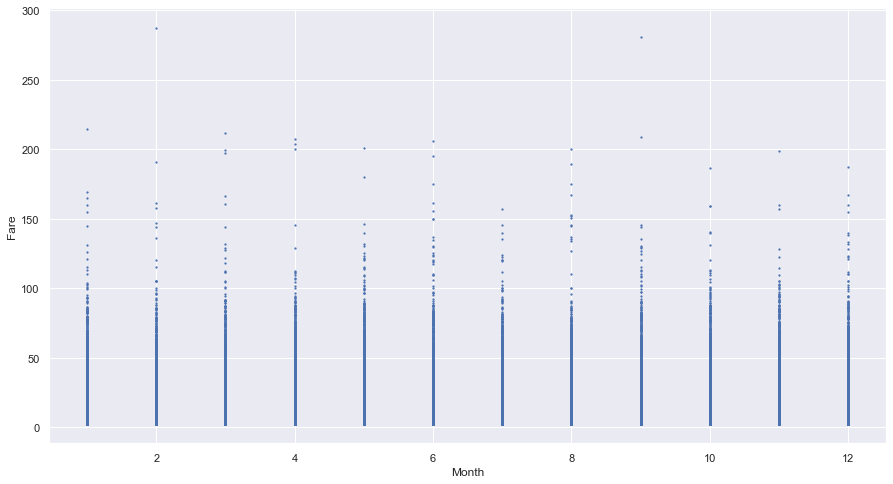

In [232]:
plt.figure(figsize=(15,8))
plt.scatter(x=train['month'], y=train['fare_amount'], s=1.5)
plt.xlabel('Month')
plt.ylabel('Fare')

* #### The rate is uniform throughout the months

Text(0, 0.5, 'Fare')

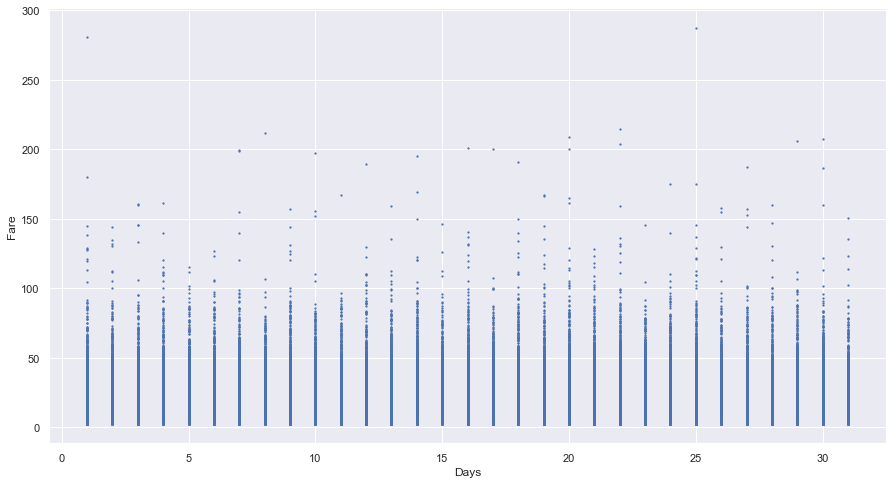

In [233]:
plt.figure(figsize=(15,8))
plt.scatter(x=train['day_of_month'], y=train['fare_amount'], s=1.5)
plt.xlabel('Days')
plt.ylabel('Fare')

* #### The fare is uniform throughout the month

In [234]:
train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'loc1', 'loc2', 'Chebyshev', 'H_Distance',
       'fare_by_distance', 'dis', 'Hour', 'day_of_week', 'day_of_month',
       'week', 'month', 'year', 'minute', 'second', 'dayofyear',
       'fare_to_dist_ratio'],
      dtype='object')

Text(0, 0.5, 'Frequency')

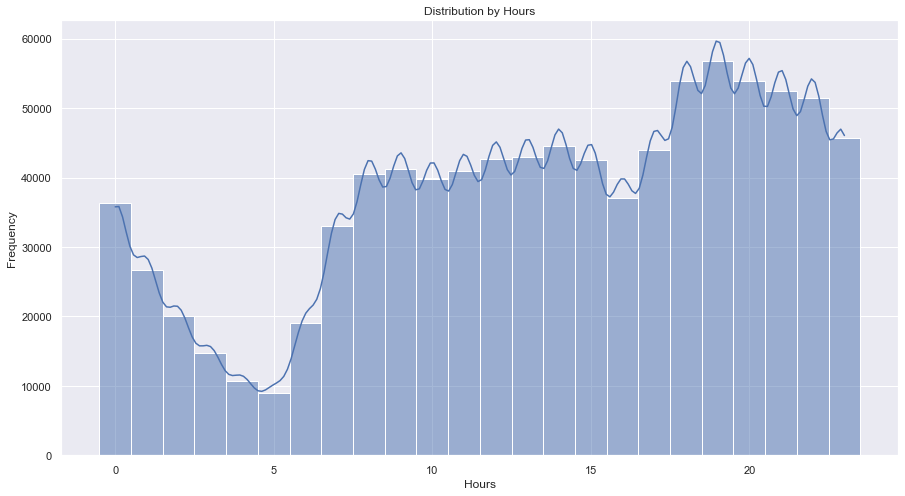

In [235]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.histplot(data=train, x="Hour", stat="count", discrete=True, kde=True)
plt.title("Distribution by Hours")
plt.xlabel('Hours')
plt.ylabel('Frequency')

* #### Taxi fares are rare at 5am and reaches the maximum at 7pm

#### 3. Does the day of the week affect the fare?

Text(0, 0.5, 'Frequency')

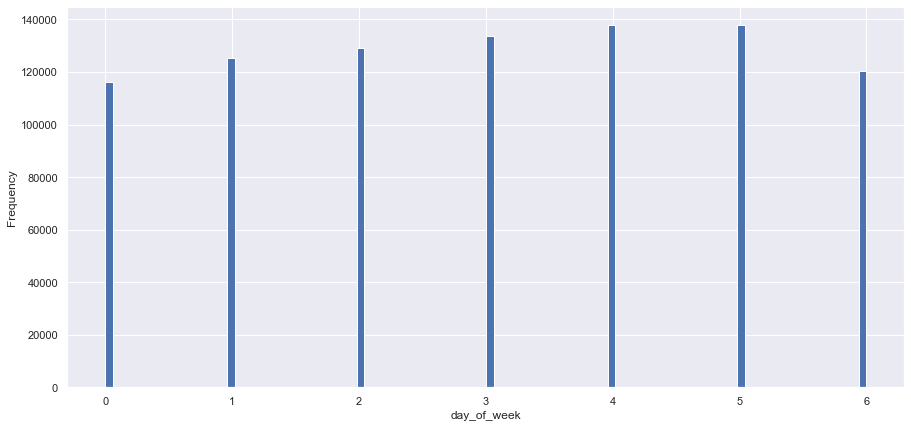

In [236]:
plt.figure(figsize=(15,7))
plt.hist(train['day_of_week'], bins=100)
plt.xlabel('day_of_week')
plt.ylabel('Frequency')
#0 means Saturday

The fares throught the month mostly seem uniform

In [237]:
train[train.passenger_count <7][['fare_amount','passenger_count']].corr()


,fare_amount,passenger_count
fare_amount,1.00000,0.00506
passenger_count,0.00506,1.00000


In [238]:
#https://www.programcreek.com/python/?CodeExample=time+slice
#**Reference**
def time_slicer(df, timeframes, value, color="purple"):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(len(timeframes), figsize = [12,12])
    for i,x in enumerate(timeframes):
        df.loc[:,[x,value]].groupby([x]).mean().plot(ax=ax[i],color=color)
        ax[i].set_ylabel(value.replace("_", " ").title())
        ax[i].set_title("{} by {}".format(value.replace("_", " ").title(), x.replace("_", " ").title()))
        ax[i].set_xlabel("")
    plt.tight_layout(pad=0)

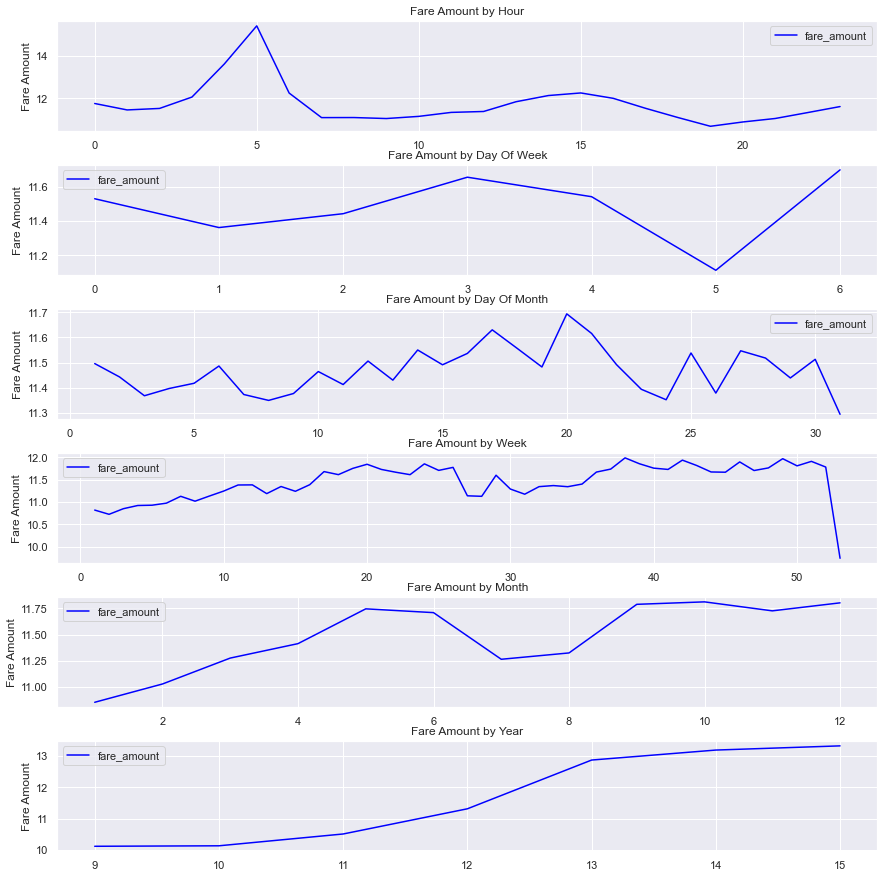

In [239]:
time_slicer(df=train, timeframes=['Hour', 'day_of_week','day_of_month', 'week', 'month', 'year',], value = "fare_amount", color="blue")

* #### The higher the demand, the lower the fee and vice versa
* #### Average fares peak on Mondays and Thursdays
* #### The average fee has been increasing over the years 

In [240]:
train[['fare_amount','H_Distance']].corr()

,fare_amount,H_Distance
fare_amount,1.000000,0.906266
H_Distance,0.906266,1.000000


* #### The correlation number between these two values is high, as a result the graphs are very similar to each other
* #### At 5 o'clock in the morning, some people who have a long distance to travel leave home early, but they are not many, so the fare increases.

#### 4. Does the distance affect the fare?

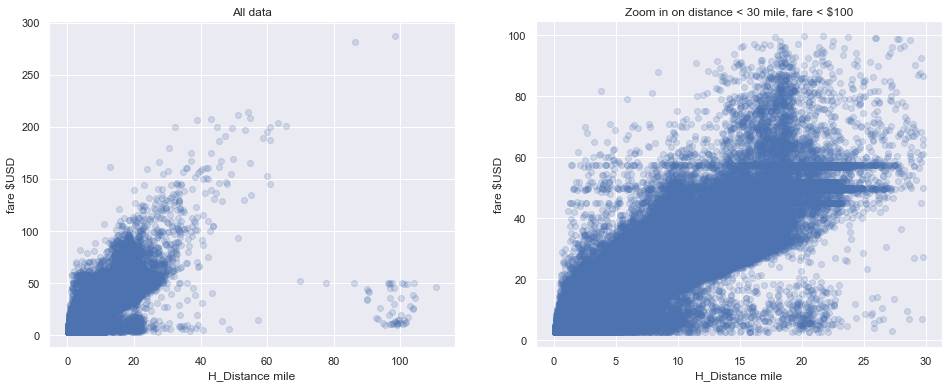

In [241]:
# scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(train.H_Distance, train.fare_amount, alpha=0.2)
axs[0].set_xlabel('H_Distance mile')
axs[0].set_ylabel('fare $USD')
axs[0].set_title('All data')

# zoom in on part of data
idx = (train.H_Distance < 30) & (train.fare_amount < 100)
axs[1].scatter(train[idx].H_Distance, train[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('H_Distance mile')
axs[1].set_ylabel('fare $USD')
axs[1].set_title('Zoom in on distance < 30 mile, fare < $100');

In [242]:
print("Average $USD/Km : {:0.2f}".format(train.fare_amount.sum()/train.H_Distance.sum()))

Average $USD/Km : 3.24


* #### The horizontal lines on the graph to the right may indicate fixed fares from the airport
* #### Overall, a linear relationship is observed

In [243]:
train.reset_index(drop=True, inplace=True)

train[train["fare_to_dist_ratio"]>500]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,loc1,loc2,...,Hour,day_of_week,day_of_month,week,month,year,minute,second,dayofyear,fare_to_dist_ratio


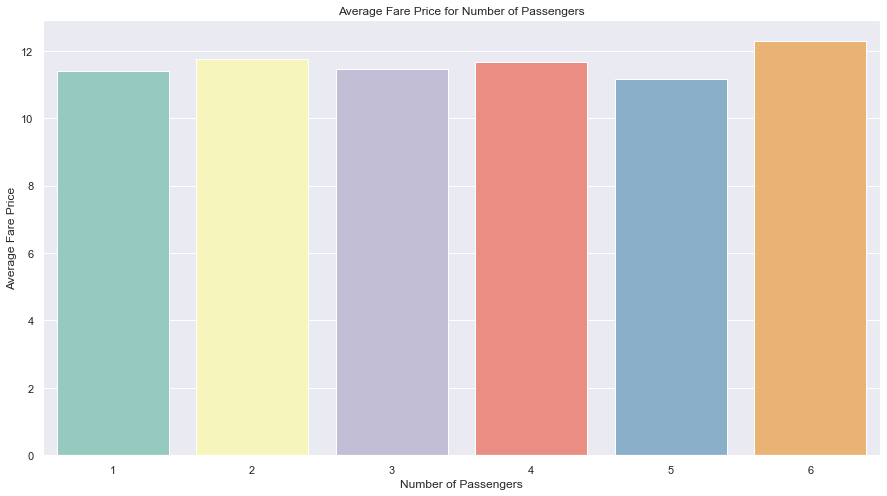

In [244]:
passenger_fare = train.groupby(['passenger_count']).mean()
sns.barplot(x=passenger_fare.index, y=passenger_fare['fare_amount'], palette = "Set3")
plt.xlabel('Number of Passengers')
plt.ylabel('Average Fare Price')
plt.title('Average Fare Price for Number of Passengers')
plt.show()

# B Data Scaling

In [245]:
from sklearn.preprocessing import StandardScaler
scalar=StandardScaler()
train2=train
train2["fare_amount"]=scalar.fit_transform(train[["fare_amount"]])
train2["passenger_count"]=scalar.fit_transform(train[["passenger_count"]])
train2["dis"]=scalar.fit_transform(train[["dis"]])
train2["fare_by_distance"]=scalar.fit_transform(train[["fare_by_distance"]])
train2['key']=scalar.fit_transform(train[['key']])
train2["pickup_datetime"]=scalar.fit_transform(train[["pickup_datetime"]])


In [246]:
train2.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,loc1,loc2,...,Hour,day_of_week,day_of_month,week,month,year,minute,second,dayofyear,fare_to_dist_ratio
0,-1.482865,-0.738076,-1.482865,-73.844315,40.721317,-73.841614,40.712276,-0.549172,"(40.721319, -73.844311)","(40.712278, -73.84161)",...,17,0,15,25,6,9,26,21,166,4.365271
1,-1.181140,0.574565,-1.181140,-74.016045,40.711304,-73.979271,40.782005,-0.549172,"(40.711303, -74.016048)","(40.782004, -73.979268)",...,16,1,5,1,1,10,52,16,5,1.999945
2,-0.309410,-0.611046,-0.309410,-73.982735,40.761269,-73.991241,40.750561,0.199800,"(40.76127, -73.982738)","(40.750562, -73.991242)",...,0,3,18,33,8,11,35,0,230,4.101825
3,0.056198,-0.399330,0.056198,-73.987129,40.733143,-73.991570,40.758091,-0.549172,"(40.733143, -73.98713)","(40.758092, -73.991567)",...,4,5,21,16,4,12,30,42,112,2.750619
4,-1.088506,-0.653389,-1.088506,-73.968094,40.768009,-73.956657,40.783764,-0.549172,"(40.768008, -73.968095)","(40.783762, -73.956655)",...,7,1,9,10,3,10,51,0,68,2.650985


In [247]:
df1 = pd.DataFrame(train2)
corr = df1.corr()
corr.style.background_gradient(cmap ='coolwarm')

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Chebyshev,H_Distance,fare_by_distance,dis,Hour,day_of_week,day_of_month,week,month,year,minute,second,dayofyear,fare_to_dist_ratio
key,1.000000,0.135806,1.000000,0.021548,-0.016836,0.016751,-0.008441,0.014265,0.032799,0.032185,0.153041,0.122676,0.002004,0.009973,-0.000118,0.028564,0.036667,0.988082,-0.000513,0.075145,0.036717,0.153073
fare_amount,0.135806,1.000000,0.135806,0.449863,-0.221276,0.339737,-0.175460,0.005060,0.917350,0.906266,-0.250758,-0.197675,-0.020644,0.000200,0.002257,0.026661,0.026457,0.130865,-0.008660,0.000890,0.026523,-0.250737
pickup_datetime,1.000000,0.135806,1.000000,0.021548,-0.016836,0.016751,-0.008441,0.014265,0.032799,0.032185,0.153041,0.122676,0.002004,0.009973,-0.000118,0.028564,0.036667,0.988082,-0.000513,0.075145,0.036717,0.153073
pickup_longitude,0.021548,0.449863,0.021548,1.000000,-0.006581,0.252102,0.055262,-0.002015,0.501384,0.478949,-0.106370,-0.080715,0.019476,-0.026265,-0.000663,0.007439,0.007163,0.020314,-0.001160,-0.007834,0.007069,-0.106374
pickup_latitude,-0.016836,-0.221276,-0.016836,-0.006581,1.000000,0.062500,0.379761,-0.005690,-0.218058,-0.218486,0.057547,0.053254,0.029961,-0.038574,-0.001061,-0.004355,-0.005189,-0.015934,0.002780,0.001886,-0.005254,0.057547
dropoff_longitude,0.016751,0.339737,0.016751,0.252102,0.062500,1.000000,0.154716,-0.004770,0.408934,0.391575,-0.145164,-0.109297,-0.050103,-0.000127,0.001919,0.005447,0.005002,0.015875,-0.004257,-0.000936,0.005125,-0.145174
dropoff_latitude,-0.008441,-0.175460,-0.008441,0.055262,0.379761,0.154716,1.000000,-0.003589,-0.159046,-0.149333,0.010274,0.012630,0.019638,-0.028381,-0.000304,-0.004857,-0.005209,-0.007595,0.001790,0.000403,-0.005203,0.010268
passenger_count,0.014265,0.005060,0.014265,-0.002015,-0.005690,-0.004770,-0.003589,1.000000,-0.010675,-0.012485,0.133592,-0.664867,0.017438,0.034798,0.004379,0.005788,0.006077,0.013175,-0.000223,-0.220469,0.006426,0.133586
Chebyshev,0.032799,0.917350,0.032799,0.501384,-0.218058,0.408934,-0.159046,-0.010675,1.000000,0.981690,-0.403373,-0.295235,-0.035614,0.009012,0.002166,0.017015,0.016624,0.030034,-0.007557,-0.000656,0.016712,-0.403379
H_Distance,0.032185,0.906266,0.032185,0.478949,-0.218486,0.391575,-0.149333,-0.012485,0.981690,1.000000,-0.445225,-0.325943,-0.034912,0.011951,0.002195,0.016992,0.016722,0.029408,-0.007530,-0.000500,0.016812,-0.445236


In [248]:
X=train[['H_Distance','month','year']].to_numpy()
X

array([[ 1.030764  ,  6.        ,  9.        ],
       [ 8.450133  ,  1.        , 10.        ],
       [ 1.3895252 ,  8.        , 11.        ],
       ...,
       [ 1.7617408 ,  4.        , 13.        ],
       [ 1.8426832 ,  7.        , 11.        ],
       [ 0.75805146, 12.        ,  9.        ]], dtype=float32)

#### Split Data

In [249]:
X=train[['H_Distance','month','year']]
#X = train.iloc[:,train.columns != "fare_amount"]
y = train["fare_amount"]
X_test = test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, test_size=0.15, random_state=3, shuffle=True)


# scaler = MinMaxScaler(feature_range=(0, 1))

# X_train_scaled = scaler.fit_transform(X_train)
# X_train = pd.DataFrame(X_train_scaled)

# X_valid_scaled = scaler.fit_transform(X_valid)
# X_valid = pd.DataFrame(X_valid_scaled)

# X_test_scaled = scaler.fit_transform(X_test)
# X_test = pd.DataFrame(X_test_scaled)

In [250]:
type(X_valid)

pandas.core.frame.DataFrame

# C Building a Pipeline:

In [251]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [252]:
class Removing_Outliers:
    def fit(self):pass
    def transform(self, train1):
        train1 = train1[train1['fare_amount']>0]
        trian1 = train1[train1['passenger_count']>0]
        haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
        train1 = train1[train1['H_Distance']>0.5]
        train1['dis']=dis
        train1 = train1[train1['dis']>=.1]
        train1 = train1[train1['dis']<=7]
        return train1



class Features_Selection:
    def fit(self):pass
    def transform(self, train1):
        train1['key'] = pd.to_datetime(train1['key'])
        train1['pickup_datetime']  = pd.to_datetime(train1['pickup_datetime'])
        train1['year'] = train1['pickup_datetime'].dt.year
        train1['Month'] = train1['pickup_datetime'].dt.month
        train1['Date'] = train1['pickup_datetime'].dt.day
        train1['Day of Week'] = train1['pickup_datetime'].dt.dayofweek
        train1['Hour'] = train1['pickup_datetime'].dt.hour
        train1 = train1.reset_index()

        return train1

class Transform:
    def fit(self):pass
    def transform(self, train1):
        a = StandardScaler()
        scaled_train_data = train1
        scaled_train_data['fare_amount'] = a.fit_transform(train1[['fare_amount']])
        scaled_train_data['passenger_count'] = a.fit_transform(train1[['passenger_count']])
        scaled_train_data['dis'] = a.fit_transform(train1[['dis']])
        scaled_train_data['fare_by_distance'] = a.fit_transform(train1[['fare_by_distance']])
        return scaled_train_data


pipe = Pipeline([
    ('anomaly remover', Removing_Outliers()),
    
    ('features selection', Features_Selection()),
    ('scaler', Transform())
])

In [253]:
data = train
data = pipe.transform(data)
print(' Resulting dataframe:', data.shape) 
data.sample(n=10)

 Resulting dataframe: (253219, 28)


,index,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,loc1,...,week,month,year,minute,second,dayofyear,fare_to_dist_ratio,Month,Date,Day of Week
83436,297027,1970-01-01 00:00:00.000000001,-0.755720,1970-01-01 00:00:00.000000001,-73.992981,40.742683,-74.009132,40.713699,0.194109,"(40.742685, -73.992983)",...,31,8,1970,52,54,214,3.430091,1,1,3
206322,733990,1969-12-31 23:59:59.999999999,2.389765,1969-12-31 23:59:59.999999999,-73.951752,40.782097,-73.789925,40.646908,0.939222,"(40.782098, -73.95175)",...,40,10,1969,11,0,274,2.442142,12,31,2
107687,383325,1970-01-01 00:00:00.000000000,0.541991,1970-01-01 00:00:00.000000000,-73.979561,40.677589,-73.950760,40.770756,-0.551004,"(40.677588, -73.979564)",...,35,8,1970,32,24,241,2.584511,1,1,3
159419,567925,1969-12-31 23:59:59.999999999,-0.747348,1969-12-31 23:59:59.999999999,-73.973373,40.763866,-73.991150,40.724804,-0.551004,"(40.763868, -73.97337)",...,7,2,1969,50,0,43,2.633290,12,31,2
132735,472590,1970-01-01 00:00:00.000000000,-0.588274,1970-01-01 00:00:00.000000000,-73.986702,40.722256,-74.004585,40.740620,-0.551004,"(40.722257, -73.986701)",...,37,9,1970,44,46,256,5.516531,1,1,3
108461,386183,1969-12-31 23:59:59.999999999,-0.111051,1969-12-31 23:59:59.999999999,-73.959785,40.781281,-73.994003,40.722694,0.194109,"(40.781282, -73.959787)",...,18,5,1969,16,0,122,2.765337,12,31,2
238738,849178,1969-12-31 23:59:59.999999999,-0.632647,1969-12-31 23:59:59.999999999,-74.016029,40.711281,-74.002739,40.680553,-0.551004,"(40.711279, -74.016026)",...,13,3,1969,3,24,90,3.746306,12,31,2
103962,370113,1970-01-01 00:00:00.000000000,0.223843,1970-01-01 00:00:00.000000000,-73.971565,40.756630,-73.864189,40.769924,2.429449,"(40.75663, -73.971568)",...,4,1,1970,51,0,24,2.586291,1,1,3
89572,318781,1970-01-01 00:00:00.000000000,-0.178029,1970-01-01 00:00:00.000000000,-73.997421,40.738522,-73.948654,40.782459,-0.551004,"(40.73852, -73.997421)",...,12,3,1970,53,38,80,2.961068,1,1,3
93551,333060,1970-01-01 00:00:00.000000000,-0.479433,1970-01-01 00:00:00.000000000,-73.951370,40.785290,-73.987625,40.753551,-0.551004,"(40.78529, -73.951373)",...,40,10,1970,51,0,278,3.278852,1,1,3


# D Use of Validation Set and Cross Validation Approach
**Reference**

https://neptune.ai/blog/cross-validation-in-machine-learning-how-to-do-it-right

https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

In [254]:
#The dataset is split into training and test dataset
newdf = df1[["fare_amount","passenger_count","H_Distance","fare_by_distance","dis","year"]].copy() 

newdf = newdf.sample(frac = 1)

In [255]:

for i in range(15): 
  k_folding = int(len(df1)/15)   #  900400/15   The training dataset is then split into K-folds.
  validation = newdf[k_folding*i:k_folding*(i+1)][['dis','fare_by_distance']]  # 1 fold is used for validation  
  training = newdf[0:k_folding*i][['dis',"fare_by_distance"]]              # Out of the K-folds, (K-1) fold is used for training
  training = training.append(newdf[k_folding*(i+1):len(newdf)][['dis',"fare_by_distance"]], ignore_index=True)
  Y = newdf[0:k_folding*i]['fare_amount']        # The model with specific hyperparameters is trained with training data (K-1 folds) and validation data as 1 fold. The performance of the model is recorded.
  Y = Y.append(newdf[k_folding*(i+1):len(newdf)]['fare_amount'], ignore_index=True)
  expected_Y = newdf[k_folding*i:k_folding*(i+1)]['fare_amount']  #The above steps (step 3, step 4, and step 5) is repeated until each of the k-fold got used for validation purpose. This is why it is called k-fold cross-validation.
  # training_mat = training.to_numpy()
  ans = np.dot(np.dot(np.linalg.inv(np.dot(training.transpose(),training)),training.transpose()),Y)  #Finally, the mean and standard deviation of the model performance is computed by taking all of the model scores calculated in step 5 for each of the K models.
  mx=0
  output_Y = [] 
  sum = 0
  for j in validation.index:
    x = validation['dis'][j]*ans[0]+validation['fare_by_distance'][j]*ans[1]
    output_Y.append(x)
    # print(expected_Y[j],output_Y)
    sum = sum + abs(expected_Y[j]-x)/expected_Y[j]
  mse = mean_squared_error(expected_Y, output_Y)
  print("Mean Squared Error for K_folding=",i, "  " ,mse)
  print("Error for K_folding",i,"  ",sum/len(validation))

Mean Squared Error for K_folding= 0    0.9287329
Error for K_folding 0    0.2009362177412589
Mean Squared Error for K_folding= 1    0.96248096
Error for K_folding 1    0.1052291077186909
Mean Squared Error for K_folding= 2    0.940493
Error for K_folding 2    0.134126122864156
Mean Squared Error for K_folding= 3    0.93793374
Error for K_folding 3    0.13055165027228924
Mean Squared Error for K_folding= 4    0.93205184
Error for K_folding 4    0.183531445415911
Mean Squared Error for K_folding= 5    0.8949848
Error for K_folding 5    0.13211003071023938
Mean Squared Error for K_folding= 6    0.94008225
Error for K_folding 6    0.20620446982639207
Mean Squared Error for K_folding= 7    0.9121175
Error for K_folding 7    0.14538032268721182
Mean Squared Error for K_folding= 8    0.9189452
Error for K_folding 8    0.20791163244715477
Mean Squared Error for K_folding= 9    0.92644155
Error for K_folding 9    0.15137719080983475
Mean Squared Error for K_folding= 10    0.95583946
Error for K

# E Linear Regression

In [256]:
def check_model(X_cols, y_col):
    X = train[X_cols].values
    # y = np.array([[x] for x in train[col].values])
    y = train[y_col].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

    models = [
        {'name_of_mmodel': 'Linear Regression','i': linear_model.LinearRegression()},
        {'name_of_mmodel': 'Ridge Regression','i': linear_model.Ridge(alpha=.1)},
        {'name_of_mmodel': 'Lasso Regularizer( Non-parametric)','i': linear_model.Lasso(alpha=0.1)}
    ]

    for i in models:
        print('Currently training {} '.format(i['name_of_mmodel']))
        i['i'].fit(X_train, y_train)
        print('Result after training on Model:', i['i'].score(X_test, y_test))
        print('Score on test set:', i['i'].coef_)
        print('\n'+'*'*20+'\n')


In [257]:
check_model(['H_Distance', 'year'], ['fare_amount'])

Currently training Linear Regression 
Result after training on Model: 0.8397013861683362
Score on test set: [[0.2425722  0.05629562]]

********************

Currently training Ridge Regression 
Result after training on Model: 0.8397015160639639
Score on test set: [[0.24257429 0.05629703]]

********************

Currently training Lasso Regularizer( Non-parametric) 
Result after training on Model: 0.8358861974319874
Score on test set: [0.23577552 0.02790221]

********************



##  K-Neighbors Regression (Non -parametric)

In [258]:
rmse_val = [] 
X = [X_train.to_numpy()]
y = [np.array(y_train.tolist())]
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train, y_train)
rmse_val=print("Score =",neigh.score(X_valid, y_valid))


# Stochastic Gradient Descent (SGD) method

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.datasets import load_boston
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

x, y = make_regression(n_samples=1000, n_features=30)


sgdr = SGDRegressor()
print(sgdr)

sgdr.fit(X_train, y_train)
rmse_val=print("Score=",sgdr.score(X_valid, y_valid))



SGDRegressor()
Score= 0.8114598808324572
